In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Number of training samples: {len(trainset)}")
print(f"Number of test samples: {len(testset)}")
print(f"Image size: {trainset[0][0].shape}") # (channels, height, width) -> 3x32x32

Using device: cpu


100%|██████████| 170M/170M [00:03<00:00, 47.2MB/s]


Number of training samples: 50000
Number of test samples: 10000
Image size: torch.Size([3, 32, 32])


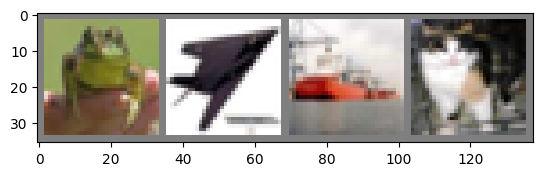

frog  plane ship  cat  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
class SimpleDNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.embedding_layer = nn.Linear(256, embedding_dim)
        self.bn_emb = nn.BatchNorm1d(embedding_dim)

        # Final classification layer
        self.fc_out = nn.Linear(embedding_dim, 10) # 10 classes

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)

        x = self.bn1(self.fc1(x))
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.bn2(self.fc2(x))
        x = torch.relu(x) + x
        x = self.dropout(x)

        embedding = self.bn_emb(self.embedding_layer(x))
        embedding = torch.relu(embedding)
        embedding = self.dropout(embedding)

        # Classification output
        output = self.fc_out(embedding)
        return output, embedding


model = SimpleDNN(embedding_dim=128).to(device)
print(model)

SimpleDNN(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layer): Linear(in_features=256, out_features=128, bias=True)
  (bn_emb): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # Zero the parameter gradients

        # Forward pass
        outputs, _ = model(inputs) # We only need outputs for classification loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Disable gradient calculations during validation
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

print('Finished Training')


Starting training...
Epoch [1/50], Train Loss: 1.7490, Train Acc: 37.16%, Val Loss: 1.5062, Val Acc: 46.19%
Epoch [2/50], Train Loss: 1.5654, Train Acc: 44.48%, Val Loss: 1.4199, Val Acc: 49.29%
Epoch [3/50], Train Loss: 1.4849, Train Acc: 47.09%, Val Loss: 1.3699, Val Acc: 51.49%
Epoch [4/50], Train Loss: 1.4369, Train Acc: 48.86%, Val Loss: 1.3377, Val Acc: 52.29%
Epoch [5/50], Train Loss: 1.3911, Train Acc: 50.62%, Val Loss: 1.3184, Val Acc: 53.14%
Epoch [6/50], Train Loss: 1.3522, Train Acc: 51.98%, Val Loss: 1.2930, Val Acc: 54.36%
Epoch [7/50], Train Loss: 1.3184, Train Acc: 53.10%, Val Loss: 1.2743, Val Acc: 54.63%
Epoch [8/50], Train Loss: 1.2869, Train Acc: 54.45%, Val Loss: 1.2530, Val Acc: 55.45%
Epoch [9/50], Train Loss: 1.2634, Train Acc: 55.10%, Val Loss: 1.2489, Val Acc: 55.32%
Epoch [10/50], Train Loss: 1.2399, Train Acc: 56.38%, Val Loss: 1.2410, Val Acc: 55.52%
Epoch [11/50], Train Loss: 1.2113, Train Acc: 56.96%, Val Loss: 1.2220, Val Acc: 56.60%
Epoch [12/50], Trai

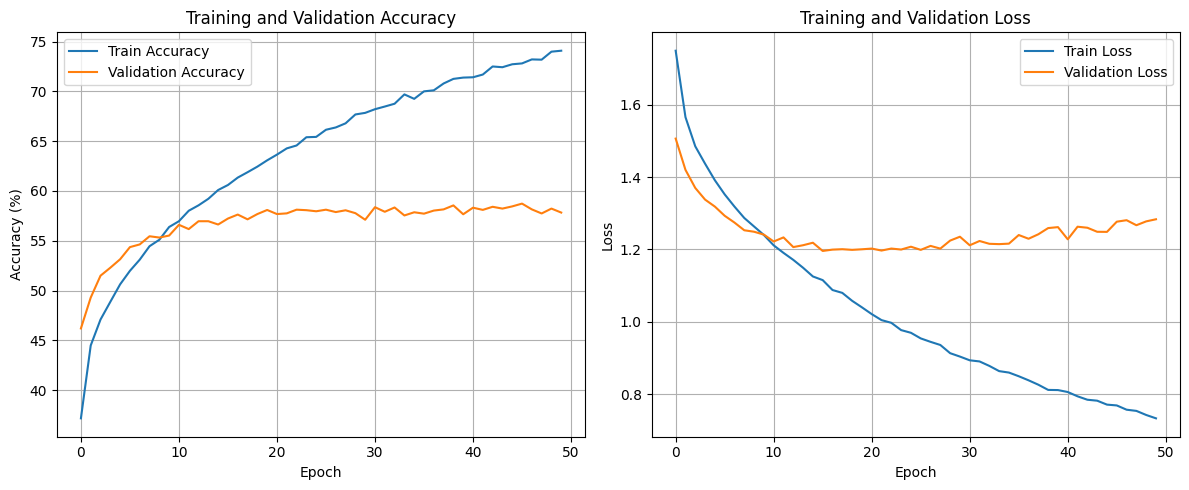

Accuracy of the network on the 10000 test images: 57.83%


In [ ]:
# Plotting training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Shape of extracted embeddings: (10000, 128)
Example embedding for the first test image:
[0.8298544  0.         0.         0.8710086  0.         0.
 0.         0.44694394 0.         0.         0.31704214 0.7619595
 0.27399525 0.         0.         0.         0.12114785 0.
 0.         0.26703697 0.         0.5199544  0.22089347 0.31501648
 0.         0.20060691 0.         1.2651337  0.         0.12068519
 0.21885864 0.         0.         0.         0.81337625 0.
 0.9647072  0.3778265  0.         0.         0.81265706 0.38277832
 0.         0.31271854 0.         0.3744577  0.         0.
 0.65635675 0.06730759 0.41240817 0.         0.12103121 0.
 0.         0.         0.09615639 0.         0.         0.
 0.         0.         0.5997411  0.4636538  0.55913156 0.
 0.3800387  0.         0.         0.         0.         0.10847864
 0.35727057 0.         0.253607   0.0841176  0.         0.
 0.         0.         0.         0.         0.         0.82048047
 0.         0.         0.         1.424

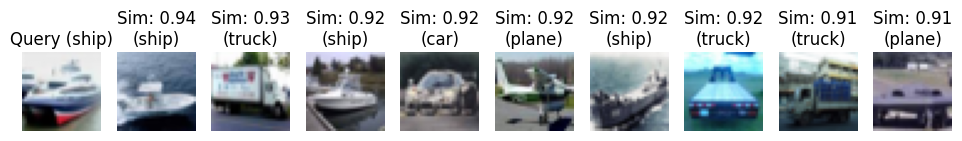

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embeddings(model, dataloader):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _, embeddings = model(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_embeddings), np.hstack(all_labels)

test_embeddings, test_labels_flat = get_embeddings(model, testloader)

print(f"Shape of extracted embeddings: {test_embeddings.shape}")
print(f"Example embedding for the first test image:\n{test_embeddings[0]}")
print(f"Shape of test labels: {test_labels_flat.shape}")
query_embedding = test_embeddings[1].reshape(1, -1) # Reshape for cosine_similarity
similarities = cosine_similarity(query_embedding, test_embeddings)[0]

# Sort and get top N most similar (excluding the query itself if present)
top_similar_indices = np.argsort(similarities)[::-1][1:10] # Get top 5, excluding the first (itself)

print(f"\nTop 5 similar images to image 0 (class: {classes[test_labels_flat[1]]}) using DNN embeddings:")
plt.figure(figsize=(12, 4))
plt.subplot(1, 10, 1)
# Unnormalize the image for display if it was normalized to [-1, 1]
display_img = testset.data[1] / 255.0 # For CIFAR-10 data, it's uint8 in [0, 255]
plt.imshow(display_img)
plt.title(f"Query ({classes[test_labels_flat[1]]})")
plt.axis('off')

# Display original images for context
for i, idx in enumerate(top_similar_indices):
    plt.subplot(1, 10, i + 2)
    display_img = testset.data[idx] / 255.0 # Get original image from dataset
    plt.imshow(display_img)
    plt.title(f"Sim: {similarities[idx]:.2f}\n({classes[test_labels_flat[idx]]})")
    plt.axis('off')
plt.show()


Top 5 least similar images to image 0 (class: ship) using DNN embeddings:


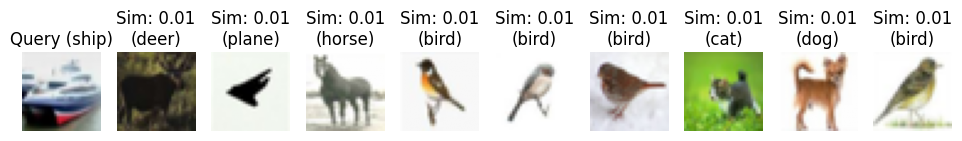

In [ ]:
top_similar_indices = np.argsort(similarities)[::-1][-10:-1] # Get top 5, excluding the first (itself)

print(f"\nTop 5 least similar images to image 0 (class: {classes[test_labels_flat[1]]}) using DNN embeddings:")
plt.figure(figsize=(12, 4))
plt.subplot(1, 10, 1)
# Unnormalize the image for display if it was normalized to [-1, 1]
display_img = testset.data[1] / 255.0 # For CIFAR-10 data, it's uint8 in [0, 255]
plt.imshow(display_img)
plt.title(f"Query ({classes[test_labels_flat[1]]})")
plt.axis('off')

# Display original images for context
for i, idx in enumerate(top_similar_indices):
    plt.subplot(1, 10, i + 2)
    display_img = testset.data[idx] / 255.0 # Get original image from dataset
    plt.imshow(display_img)
    plt.title(f"Sim: {similarities[idx]:.2f}\n({classes[test_labels_flat[idx]]})")
    plt.axis('off')
plt.show()

In [ ]:
we want emb size as 128

Input: (256*256*3,1)
1st Layer: (256*256*3, 512)
o:1x512
2nd layer: (512, 256)
o:1x256
3rd layer: (256, 128)
o:1x128 -> has highly compact/condensed image info
outpur layer: (128, 10)

In [ ]:
loss = np.sum(y*log(A)) + (lambda/2)*|| W[0:L]||2

dw5 = dW(old) + (lamda*W5)

Wn = W0 - (dw5)